# Exploring Airbnb Data in Amsterdam

Data was collected from [InsideAirbnb](http://insideairbnb.com/) as of March 9th, 2023.

In [244]:
# Import all neccessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import seaborn as sns
from wordcloud import WordCloud
import contextily  # Background tiles
from pysal.lib import weights  # Spatial weights

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/

In [2]:
# Read in the listing data
listings_df = pd.read_csv("data/listings.csv")
listings_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2818,Quiet Garden View Room & Super Fast Wi-Fi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.36435,4.94358,Private room,69,3,322,2023-02-28,1.90,1,44,37,0363 5F3A 5684 6750 D14D
1,20168,Studio with private bathroom in the centre 1,59484,Alexander,NaN,Centrum-Oost,52.36407,4.89393,Private room,106,1,339,2020-04-09,2.14,2,0,0,0363 CBB3 2C10 0C2A 1E29
2,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,NaN,Centrum-West,52.38761,4.89188,Private room,143,3,248,2023-02-26,1.82,1,14,20,0363 974D 4986 7411 88D8
3,28871,Comfortable double room,124245,Edwin,NaN,Centrum-West,52.36775,4.89092,Private room,76,2,476,2023-02-28,3.12,2,79,97,0363 607B EA74 0BD8 2F6F
4,29051,Comfortable single room,124245,Edwin,NaN,Centrum-Oost,52.36584,4.89111,Private room,56,2,618,2023-03-03,4.23,2,69,85,0363 607B EA74 0BD8 2F6F


In [233]:
print(listings_df['license'].isna().sum())

# listings_df[listings_df["license"].apply(lambda x: str(x) == "unlicensed")] # 5697
listings_df.value_counts("license")

24


license
Exempt                      580
0363 78AD 8875 790E 3C05     13
ABCD 1234 AB12 89EF A0F9     10
036341086EC3C2FF2493          7
0363 7AE5 8749 D05C F51D      5
                           ... 
0363 6498 1BC9 649B 386D      1
0363 6482 8965 792C A79C      1
0363 646B B9D1 BE61 482E      1
0363 6467 4DA6 8A67 C002      1
abcd 1234 AB12 89EF A0F9      1
Length: 5963, dtype: int64

## Listing Data Analysis

We can begin by understanding the data we are working with. We can see the different data points available to us above. Plotting according to neighbourhood (as seen below) allows us to see the listings, alongside the outlines of the neighbourhoods. Later on we'll be using a neighbourhood geojson file to conduct spatial analysis.

[]

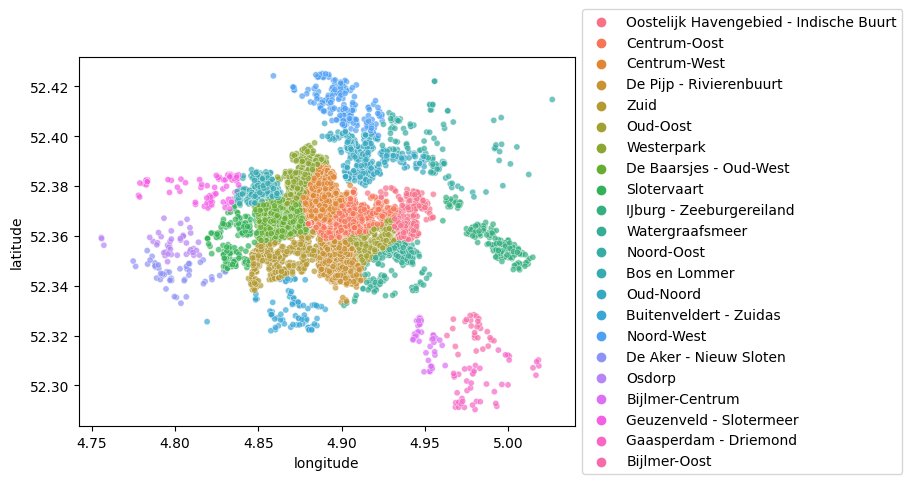

In [167]:
# diverging_colors = sns.color_palette("RdBu", 10)
# sns.palplot(diverging_colors)
scatter = sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood', 
                          alpha=0.7, s=20, data=listings_df)
scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# scatter.color_palette("RdBu", 10)
scatter.plot()

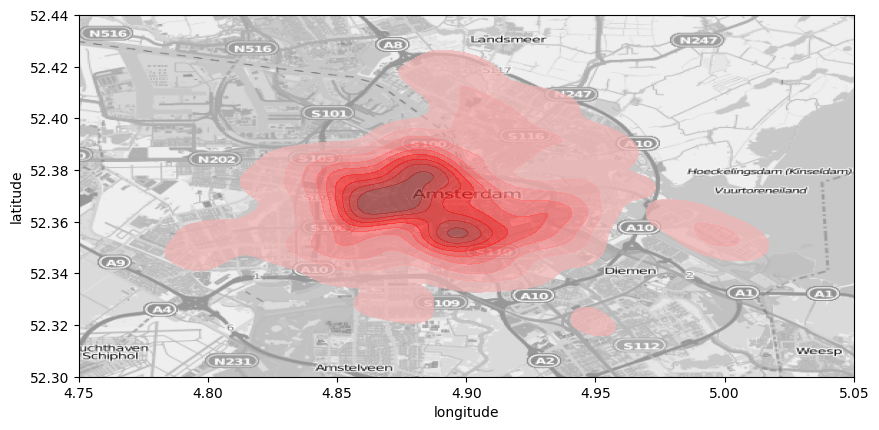

In [241]:
plt.figure(figsize=(10,8))
# i = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/c/c2/Map_NL_-_Amsterdam_-.png')
# ams_city = plt.imread('https://upload.wikimedia.org/wikipedia/commons/c/c2/Map_NL_-_Amsterdam_-.png')

map_img = plt.imread("data/image.png")


plt.imshow(map_img,zorder=0,extent=[4.699, 5.125, 52.247, 52.496])

# sns.kdeplot(
#     data=listings_df, x="longitude", y="latitude", fill=True, alpha=0.5, color="red"
# )
sns.kdeplot(
    data=listings_df, x="longitude", y="latitude", fill=True, alpha=0.7, color="red"
)

plt.axis([4.75, 5.05, 52.30, 52.44])
plt.show()

<Figure size 1000x800 with 0 Axes>

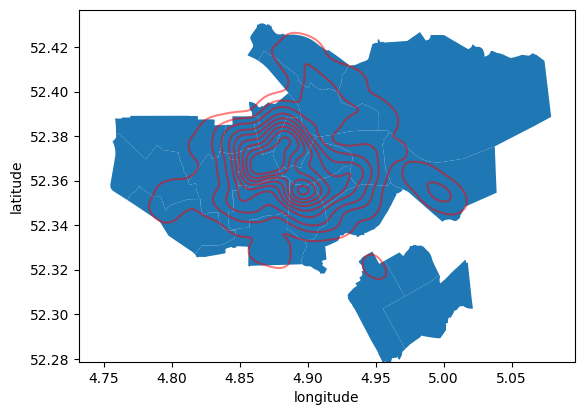

In [212]:
plt.figure(figsize=(10,8))
# i = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/c/c2/Map_NL_-_Amsterdam_-.png')
# ams_city = plt.imread('https://upload.wikimedia.org/wikipedia/commons/c/c2/Map_NL_-_Amsterdam_-.png')

# map_img = plt.imread("data/amsterdam.png")


# plt.imshow(map_img,zorder=0,extent=[4.699, 5.125, 52.247, 52.496])

# sns.kdeplot(
#     data=listings_df, x="longitude", y="latitude", fill=True, alpha=0.5, color="red"
# )


neighbourhoods_gdf = gpd.read_file('data/neighbourhoods.geojson').to_crs(epsg=4326) # WGS84 Latitude/Longitude

neighbourhoods_gdf.plot()


sns.kdeplot(
    data=listings_df, x="longitude", y="latitude", fill=False, alpha=0.5, color="red"
)

# plt.axis([4.75, 5.05, 52.30, 52.44])
plt.show()

([<matplotlib.patches.Wedge at 0x135cc3310>,
 [Text(-0.7508945216077499, 0.8174701324326588, 'Entire home/apt'),
  Text(0.7387662896703235, -0.8813196748324322, 'Private room'),
  Text(1.7964460895551984, -0.11305506322954759, 'Hotel room'),
  Text(1.3997854322792505, -0.02451007096669022, 'Shared room')],
 [Text(-0.4126537461087634, 0.44924034304857824, '73.6%(5154)'),
  Text(0.41756355503105236, -0.4981372075139833, '24.9%(1743)'),
  Text(1.2974332869009764, -0.0816508789991177, '0.9%(62)'),
  Text(0.8998620636080894, -0.015756474192872284, '0.6%(39)')])

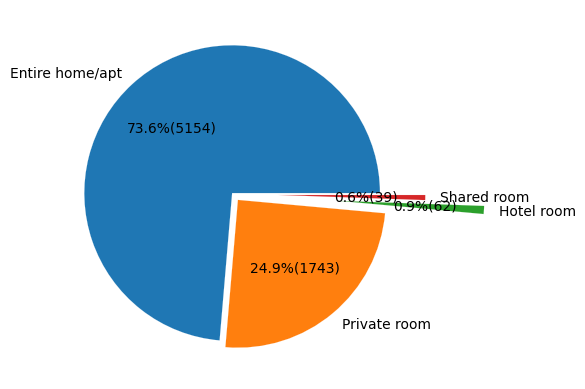

In [214]:
# total = listings_df['room_type'].value_counts().values.sum()

def fmt(x):
    return '{:.1f}%({:.0f})'.format(x, total*x/100)

plt.pie(listings_df['room_type'].value_counts().values, 
        labels=listings_df['room_type'].value_counts().index, 
        autopct=fmt,
        explode = (0.01, 0.05, 0.7, 0.3),
        wedgeprops= {"edgecolor":"white",
                     'linewidth': 0.1,
                     'antialiased': True},
        #pctdistance=1,1
       )
# plt.legend(loc="best")

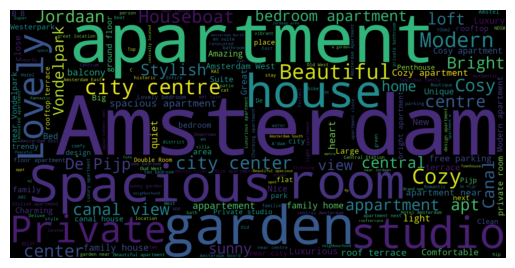

<Figure size 2000x1000 with 0 Axes>

In [116]:
# We can even create a beautiful looking wordcloud from the names of the Airbnb Listings
# Although we can't extract much useful information from this plot, it is still aesthetically pleasing
# and funny to see all the different ways people are spelling "apartment" :P

text = ""
for name in listings_df['name']: # Collect all listing names into single string
    text += " " + name

# Create the wordcloud object
wordcloud = WordCloud(width=960, height=480).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

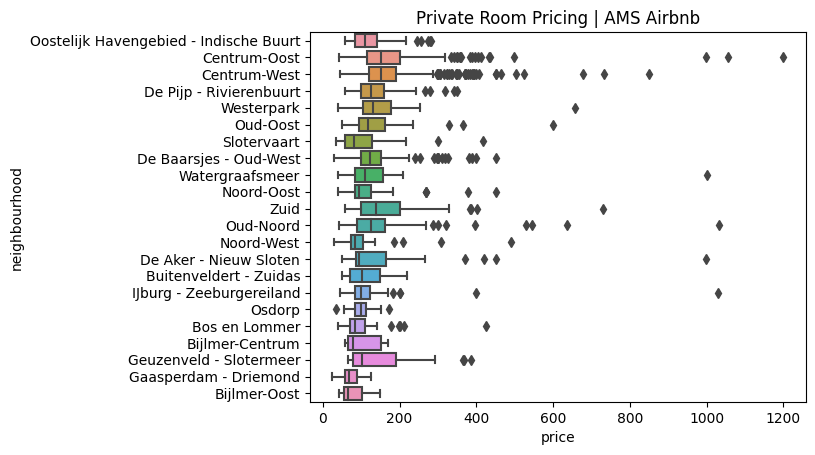

In [46]:
subset = listings_df.loc[listings_df['room_type'].isin(["Private room"])]
sns.boxplot(x='price', y='neighbourhood', data=subset).set_title("Private Room Pricing | AMS Airbnb")
plt.show()

EPSG:4326


<Axes: >

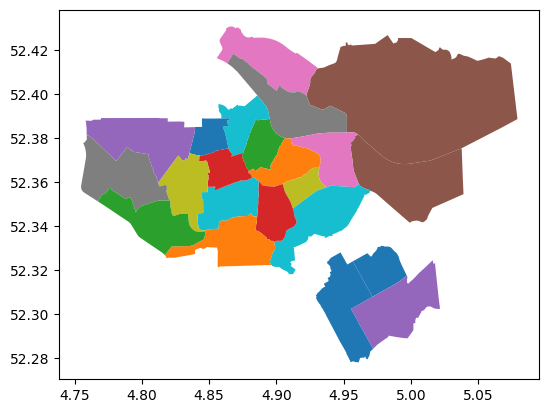

In [31]:
neighbourhoods_gdf = gpd.read_file('data/boroughs.geojson').to_crs(epsg=4326) # WGS84 Latitude/Longitude

listings_gdf = gpd.GeoDataFrame(
    listings_df, geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude), crs="EPSG:4326" 
)

print(neighbourhoods_gdf.crs)
neighbourhoods_gdf.plot(column = "neighbourhood")

In [26]:
# join_left_df = gpd.sjoin(listings_gdf, neighbourhoods_gdf, how="inner", predicate="within")
# join_left_df.head()
grouped = listings_gdf.groupby('neighbourhood').mean()
merged = pd.merge(neighbourhoods_gdf, grouped, on="neighbourhood")

data_map = folium.Map(location=[52.377956, 4.897070], zoom_start=11)
folium.GeoJson(merged, name="geojson",
                tooltip=folium.features.GeoJsonTooltip(
                    fields=['neighbourhood', 'price'],
                    aliases=['Neighbourhood name:', 'Average price'],
                )
              ).add_to(data_map)
data_map
# folium.GeoJson(listings_gdf, name="geojson",
#                 tooltip=folium.features.GeoJsonTooltip(
#                     fields=['neighbourhood'],
#                     aliases=['Neighbourhood name:'],
#                 )
#               ).add_to(data_map)

/var/folders/ky/nl9r2_y11n13lb7wdfnhzby80000gn/T/ipykernel_3197/3851523327.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = listings_gdf.groupby('neighbourhood').mean()


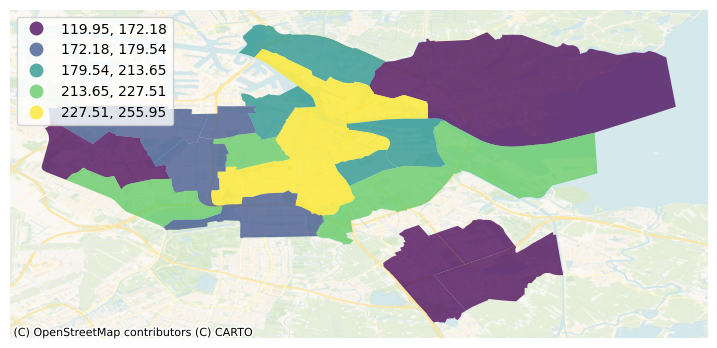

In [239]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
merged.plot(
    column="price",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=merged.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

In [246]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(merged, k=3)
# Row-standardization
w.transform = "R"

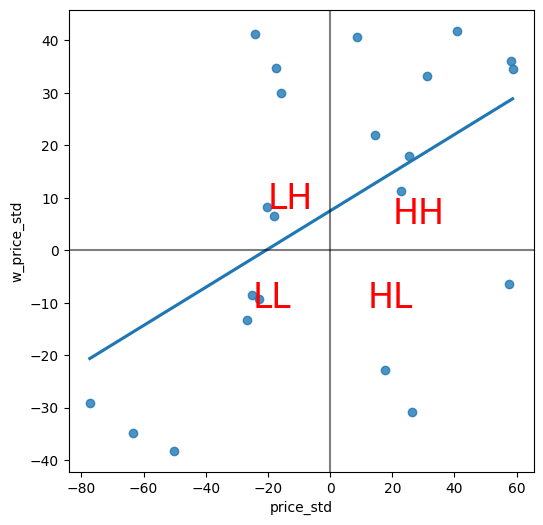

In [251]:
merged["w_price"] = weights.lag_spatial(w, merged['price'])

merged["price_std"] = merged["price"] - merged["price"].mean()
merged["w_price_std"] = weights.lag_spatial(w, merged['price_std'])


# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="price_std", y="w_price_std", data=merged, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()